# Libraries

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import tensorflow as tf
import keras
from keras.callbacks import ModelCheckpoint
import random

# Functions

In [50]:
def extract_points(plot):

    plot_points = np.zeros_like(plot,dtype=np.int32)

    plot_points[plot > 127] = 255


    return plot_points

In [51]:
def generate_random_points(black_points,num_points):

    selected_indices = np.random.choice(black_points.shape[0], size=num_points, replace=False)
    selected_points = black_points[selected_indices]
    x_train = selected_points[:, 1]
    y_train = selected_points[:, 0]

    return x_train, y_train

In [62]:
def drop_noisy_points(noised_dataset,threshold):

    x = noised_dataset[0][0]

    size = noised_dataset.shape[0]

    noisy_points = []

    for i in range(1,size):
      if (np.abs(noised_dataset[i][0] - x) < ( x * threshold)):
        x = noised_dataset[i][0]
      else:
        noisy_points.append(i)

    denoised_dataset = np.delete(noised_dataset,noisy_points,axis=0)
    print(denoised_dataset.shape)
    return denoised_dataset

In [53]:
def create_model(num_layers, num_neurons, activation_func):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(num_neurons, activation=activation_func, input_shape=(1,)))

    for _ in range(num_layers - 1):
        model.add(tf.keras.layers.Dense(num_neurons, activation=activation_func))

    model.add(tf.keras.layers.Dense(1))

    return model


def train_model(model, x_train, y_train, num_epochs, validation_split):
    learning_rate_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=10000,
    decay_rate=0.96)

    check_point = ModelCheckpoint( '.mdl_wts.hdf5',save_best_only=True, monitor='val_loss', mode='min')

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_schedule)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    model.fit(x_train, y_train, epochs=num_epochs, batch_size=100, validation_split=validation_split,callbacks=[check_point])


def evaluate_model(model, black_points, tolerance=0.1):

    x = black_points[:,1]
    y_target = black_points[:,0]
    y_pred = model.predict(x, batch_size=1000)

    correct_predictions = np.sum(np.abs((y_pred.flatten() - y_target) / (y_target * 1.0)) < tolerance)
    precision = correct_predictions / len(black_points) * 100

    plt.scatter(x,y_target , label='Target Function')
    plt.scatter(x , y_pred, label='Approximated Function')
    plt.legend()
    plt.show()

    return precision

# Train without Noises

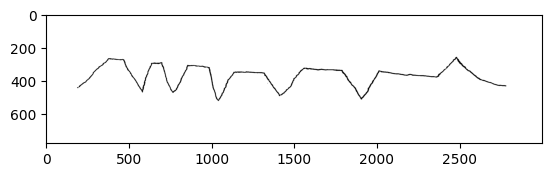

In [18]:
plot = cv2.imread('/content/plot.jpg',cv2.IMREAD_GRAYSCALE)
plot_points = extract_points(plot)
plt.imshow(plot_points,cmap='gray')
plt.show()

In [11]:
indices = np.argwhere(plot_points == 0)
print(indices.shape)

(24110, 2)


(2596, 2)


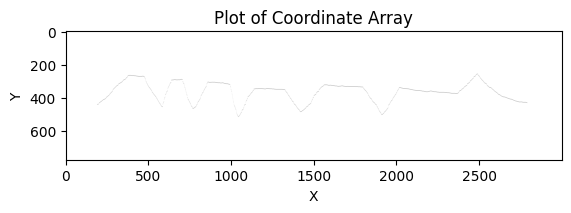

In [19]:
black_points = np.argwhere(plot_points == 0)

_, unique_indices = np.unique(black_points[:, 1], return_index=True)
unique_black_points = black_points[unique_indices]

print(unique_black_points.shape)
max_x = np.max(unique_black_points[:, 1])
max_y = np.max(unique_black_points[:, 0])


image = np.ones((776,3000))

for y, x in unique_black_points:
    image[int(y), int(x)] = 0

plt.imshow(image, cmap='gray')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Plot of Coordinate Array')
plt.show()

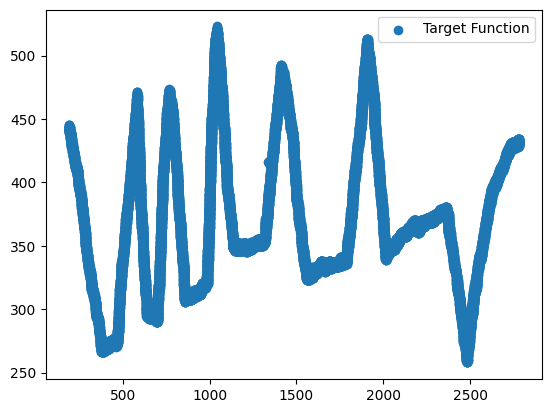

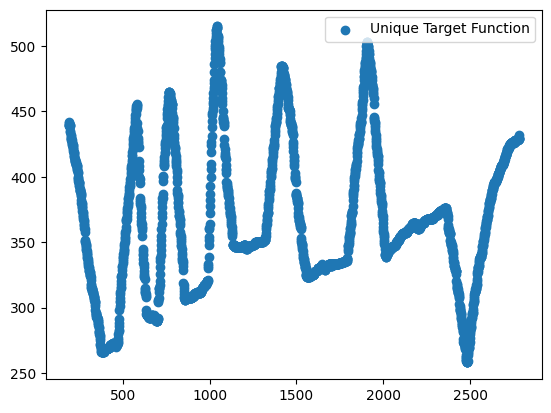

In [13]:
plt.scatter(black_points[:,1], black_points[:,0], label='Target Function')
plt.legend()
plt.show()
plt.scatter(unique_black_points[:,1], unique_black_points[:,0], label='Unique Target Function')
plt.legend()
plt.show()

In [17]:
num_points = 2596
num_layers = 5
num_neurons = 64
activation_func = 'relu'
num_epochs = 1000
validation_split = 0.2

x_train, y_train = generate_random_points(unique_black_points, num_points)

model = create_model(num_layers, num_neurons, activation_func)
train_model(model, x_train, y_train, num_epochs, validation_split)

Epoch 1/1000
21/21 [==============================] - 2s 18ms/step - loss: 40972.3633 - val_loss: 29017.3613
Epoch 2/1000
21/21 [==============================] - 0s 8ms/step - loss: 28792.1543 - val_loss: 31181.8047
Epoch 3/1000
21/21 [==============================] - 0s 10ms/step - loss: 28063.9141 - val_loss: 28620.7734
Epoch 4/1000
21/21 [==============================] - 0s 8ms/step - loss: 27466.8516 - val_loss: 29260.9922
Epoch 5/1000
21/21 [==============================] - 0s 11ms/step - loss: 27660.7207 - val_loss: 28552.2461
Epoch 6/1000
21/21 [==============================] - 0s 10ms/step - loss: 26948.3770 - val_loss: 27846.6250
Epoch 7/1000
21/21 [==============================] - 0s 10ms/step - loss: 26737.2207 - val_loss: 31339.4551
Epoch 8/1000
21/21 [==============================] - 0s 7ms/step - loss: 26730.3125 - val_loss: 27804.7383
Epoch 9/1000
21/21 [==============================] - 0s 8ms/step - loss: 26212.7910 - val_loss: 27425.3691
Epoch 10/1000
21/21 [==

3/3 [==============================] - 0s 3ms/step


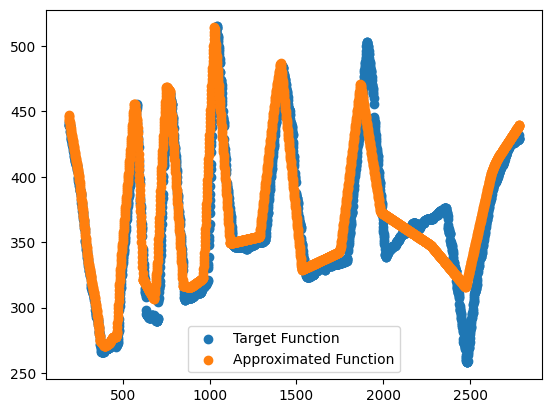

Precision: 88.21%


In [18]:
precision = evaluate_model(model, unique_black_points)

print("Precision: {:.2f}%".format(precision))

# Train with Noises

In [57]:
num_random_noises = 100

x = unique_black_points[:,1]
y = unique_black_points[:,0]

range_of_function_y = np.arange(250,600)

random_y = random.sample(list(range_of_function_y),num_random_noises)
random_y_indices = random.sample(range(y.shape[0]),num_random_noises)


noised_dataset = unique_black_points.copy()

noised_dataset[:,0][random_y_indices] = random_y

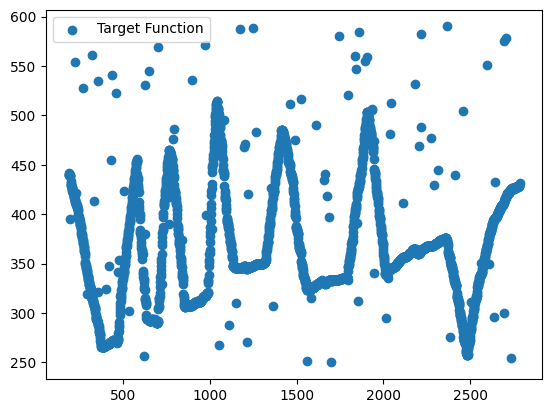

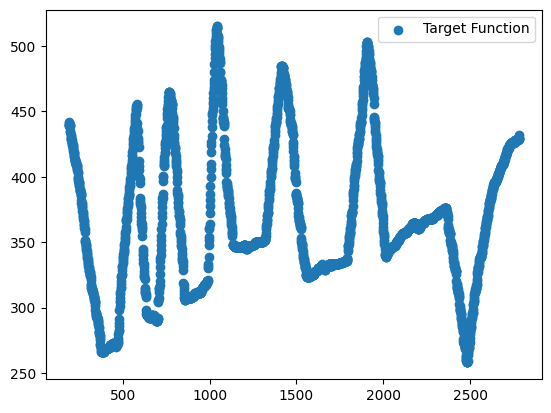

In [58]:
plt.scatter(noised_dataset[:,1], noised_dataset[:,0], label='Target Function')
plt.legend()
plt.show()
plt.scatter(unique_black_points[:,1], unique_black_points[:,0], label='Target Function')
plt.legend()
plt.show()

(2413, 2)


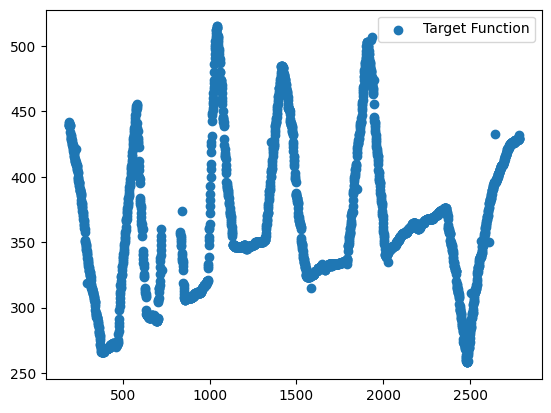

In [63]:
threshold = 0.1

denoised_dataset = drop_noisy_points(noised_dataset,threshold)

plt.scatter(denoised_dataset[:,1], denoised_dataset[:,0], label='Target Function')
plt.legend()
plt.show()


In [60]:
num_points = denoised_dataset.shape[0]
num_layers = 5
num_neurons = 64
activation_func = 'relu'
num_epochs = 1000
validation_split = 0.2

x_train, y_train = generate_random_points(denoised_dataset, num_points)

model = create_model(num_layers, num_neurons, activation_func)
train_model(model, x_train, y_train, num_epochs, validation_split)


Epoch 1/1000
20/20 [==============================] - 2s 17ms/step - loss: 42041.3984 - val_loss: 27554.6133
Epoch 2/1000
20/20 [==============================] - 0s 7ms/step - loss: 26102.6855 - val_loss: 27098.0312
Epoch 3/1000
20/20 [==============================] - 0s 7ms/step - loss: 26145.9277 - val_loss: 27070.5566
Epoch 4/1000
20/20 [==============================] - 0s 7ms/step - loss: 25571.5098 - val_loss: 26977.0469
Epoch 5/1000
20/20 [==============================] - 0s 8ms/step - loss: 25430.4648 - val_loss: 26814.9219
Epoch 6/1000
20/20 [==============================] - 0s 5ms/step - loss: 25027.5723 - val_loss: 27823.2109
Epoch 7/1000
20/20 [==============================] - 0s 8ms/step - loss: 25521.3906 - val_loss: 25979.7930
Epoch 8/1000
20/20 [==============================] - 0s 7ms/step - loss: 25071.0059 - val_loss: 25702.7598
Epoch 9/1000
20/20 [==============================] - 0s 6ms/step - loss: 24388.7051 - val_loss: 28891.0312
Epoch 10/1000
20/20 [======

3/3 [==============================] - 0s 8ms/step


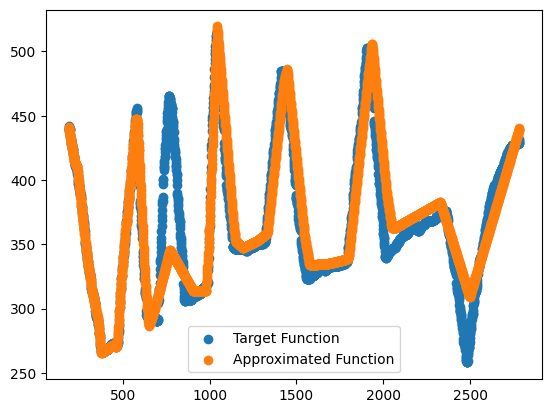

Precision: 90.22%


In [64]:
precision = evaluate_model(model, unique_black_points)

print("Precision: {:.2f}%".format(precision))

3/3 [==============================] - 0s 7ms/step


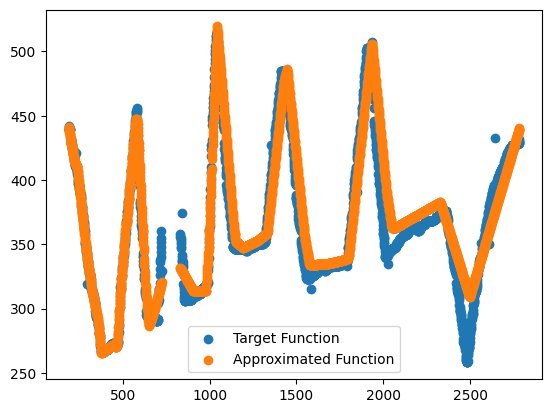

Precision: 93.74%


In [65]:
precision = evaluate_model(model, denoised_dataset)

print("Precision: {:.2f}%".format(precision))